In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import numpy as np
import itertools as it

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU 

Using TensorFlow backend.


In [2]:
(x_train0, y_train0), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
##Data generation

x_train = x_train0[:50000]
y_train = y_train0[:50000]
x_hold = x_train0[50000:]
y_hold = y_train0[50000:]

#Data for CNN

x_test_CNN = x_test.reshape(10000,28,28,1)
x_train_CNN = x_train.reshape(50000,28,28,1)
x_hold_CNN = x_hold.reshape(10000,28,28,1)
x_test_CNN = x_test_CNN.astype('float32')
x_train_CNN = x_train_CNN.astype('float32')
x_hold_CNN = x_hold_CNN.astype('float32')
x_test_CNN = x_test_CNN/255
x_train_CNN = x_train_CNN/255
x_hold_CNN = x_hold_CNN/255


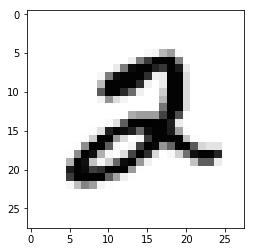

In [4]:
y_train.shape
plt.imshow(x_train[5], cmap='Greys')

In [5]:
x_train_flat = np.array([x.reshape((784)) for x in x_train])
x_test_flat = np.array([x.reshape((784))for x in x_test])
x_train_flat.shape
#"Unrolled" MNIST array is numbered left to right, top to bottom., so first entry of each unrolled vector is top-left pixel

(50000, 784)

In [6]:
def GF00(j):
    return(np.exp((1/1.4)*(-(np.floor(j/28)-13.5)**2-(j%28 - 13.5)**2)))

#Handle r=0 case specially

GF = np.zeros((193,784))

GF[0,] = [GF00(x) for x in np.arange(784)] 
for i in range(1,32*6+1):
    for j in range(784):
        r = 2*(np.floor((i-1)/32)+1)
        t = (i-1)%32*(2*np.pi/32)
        u = 27-np.floor(j/28)
        v = j%28
        GF[i,j] = np.exp((-(v-13.5-r*math.cos(t))**2-(u-13.5-r*math.sin(t))**2)/(2*(.01*r+.7)))

In [7]:
x_train_rot_nonorm = np.transpose(np.matmul(GF, np.transpose(x_train_flat)))
x_test_rot_nonorm = np.transpose(np.matmul(GF, np.transpose(x_test_flat)))

#Now normalize each image by dividing image values by max pixel intensity. 

x_train_rot = np.transpose(np.transpose(x_train_rot_nonorm)/np.amax(x_train_rot_nonorm,axis=1))
x_test_rot = np.transpose(np.transpose(x_test_rot_nonorm)/np.amax(x_test_rot_nonorm,axis=1))

#Entries of x_train_rot in dictionary order (r,theta)

#Check normalization works
print(max(x_test_rot[55]), max(x_train_rot[66]))

1.0 1.0


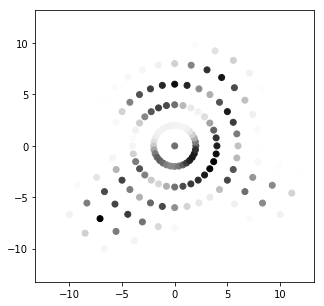

In [60]:
rot_plot(x_train_rot[5])

In [8]:
def rot_plot(image):
    dum = np.array(range(192))
    rad = 2*(np.floor(dum/32)+1)
    theta = (dum)%32*(2*np.pi/32)
    x_coord = np.concatenate(([0],np.multiply(rad,np.cos(theta))))
    y_coord = np.concatenate(([0],np.multiply(rad, np.sin(theta))))
    
    plt.figure(figsize=(5,5))
    plt.scatter(x = x_coord, y = y_coord, c = image,cmap="Greys")
    plt.show()

Number is 2


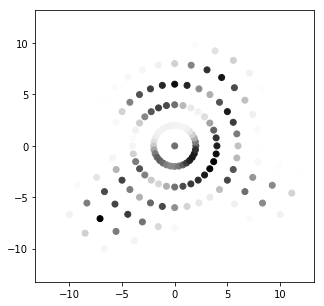

In [9]:
print("Number is",y_train[5])
rot_plot(x_train_rot[5])

In [10]:
# def firstdeg(x_train_rot):
#     dummy = np.empty(7)
    
#     dummy[0] = x_train_rot[0]
#     for i in range(6):
#         dummy[i+1] = np.sum(x_train_rot[(32*i+1):(32*i+33)])/32 #32*i+1 selects the radius
#     return(dummy)
# #FRANK!!! REMEMBER INDEXING [1:3] ONLY SELECTS ENTRIES 1 AND 2!!!

In [11]:
def firstdeg_mat(x_train_rot):
    
    dummy = x_train_rot[:,0]
    for i in range(6):
        dummy = np.column_stack((dummy,np.sum(x_train_rot[:,(32*i+1):(32*i+33)],axis=1)/32)) #32*i+1 selects the radius
    return(dummy)

In [12]:
# def secdeg(x_train_rot):
#     dummy = [x_train_rot[0]**2]
    
#     #Here calculate the terms involving center point
#     for r in range(6):
#         dummy.append(np.sum(x_train_rot[0]*x_train_rot[(r*32+1):(r*32+33)])/32)
        
#     #Then, calculate everything else
#     for i in range(6):
#         for j in range(6):
#             for k in range(17):
#                 if k == 0 and i<j: #don't double count these special pairs
#                     continue
                    
#                 total = 0
                
#                 for s in range(32):
#                     total += x_train_rot[i*32+1+s]*x_train_rot[j*32+1+(k+s)%32]
                    
#                 dummy.append(total/32)
    
#     return(np.array(dummy))

In [13]:
def secdeg_mat(x_train_rot):
    dummy = x_train_rot[:,0]**2
    
    for r in range(6):
        dummy = np.column_stack((dummy,
                np.sum(x_train_rot[:,(r*32+1):(r*32+33)]*(x_train_rot[:,0])[:,np.newaxis],axis=1)/32))
        
    #Then, calculate everything else
    for i in range(6):
        for j in range(6):
            for k in range(17):
                if k == 0 and i<j: #don't double count these special pairs
                    continue 
                    
                total = np.zeros(x_train_rot.shape[0])

                for s in range(32):
                    total = total+x_train_rot[:,(i*32+1+s)]*x_train_rot[:,(j*32+1+(k+s)%32)]
                    
                dummy = np.column_stack((dummy,total/32))
    
    return(np.array(dummy))

In [14]:
# def thirdeg(x_train_rot):
#     #Only calculate triangles with vertices on same radius, angles.
#     #Fixing the minimal angle, there is a bijection (?):
#     dummy = []
#     for r in range(6):
#         for i in range(1,6):
#             for j in range(16):
#                 if j < i or j > (16 - 2*i):
#                     continue
#                 total = 0
#                 for s in range(32):
#                     total += x_train_rot[32*r+1+s]*x_train_rot[32*r+1+(2*i+s)%32]*x_train_rot[32*r+1+(2*(i+j)+s)%32]
                
#                 dummy.append(total/32)
                
#     return(np.array(dummy))
            

In [15]:
def thirdeg_mat(x_train_rot):
    #Only calculate triangles with vertices on same radius, angles.
    #Fixing the minimal angle, there is a bijection (?):
    dummy = np.empty((x_train_rot.shape[0],0))
    for r in range(6):
        for i in range(1,6):
            for j in range(16):
                if j < i or j > (16 - 2*i):
                    continue
                total = np.zeros(x_train_rot.shape[0])
                for s in range(32):
                    total = total+ x_train_rot[:,(32*r+1+s)]*x_train_rot[:,(32*r+1+(2*i+s)%32)]*x_train_rot[:,(32*r+1+(2*(i+j)+s)%32)]
                
                dummy = np.column_stack((dummy,total/32))
                
    return(np.array(dummy))

In [16]:
# def rot_features(x_train_rot):
#     return(np.concatenate([firstdeg(x_train_rot),secdeg(x_train_rot),thirdeg(x_train_rot)]))
def rot_features(x_train_rot):
    return(np.column_stack((firstdeg_mat(x_train_rot),secdeg_mat(x_train_rot),thirdeg_mat(x_train_rot))))

In [17]:
x_train_features = rot_features(x_train_rot)
x_test_features = rot_features(x_test_rot)

In [18]:
x_train_features.shape

(50000, 851)

In [19]:
model = keras.Sequential([
    #keras.layers.Dropout(.3,input_shape = (x_train_features.shape[1],), noise_shape=None, seed=None),
    keras.layers.Dense(200, input_shape = (x_train_features.shape[1],), activation=tf.nn.relu),
    #keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    #keras.layers.Dense(100, activation = tf.nn.relu),
    keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='sgd', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#adding a second layer here makes it train much faster and get to much high levels of accuracy.

Instructions for updating:
Colocations handled automatically by placer.


In [40]:
model.fit(x_train_features, y_train, verbose=1, epochs= 45)

Epoch 1/30
50000/50000 [==============================] - 4s 85us/sample - loss: 0.2369 - acc: 0.9279
Epoch 2/30
50000/50000 [==============================] - 4s 81us/sample - loss: 0.2329 - acc: 0.9295
Epoch 3/30
50000/50000 [==============================] - 4s 81us/sample - loss: 0.2297 - acc: 0.9304
Epoch 4/30
50000/50000 [==============================] - 4s 84us/sample - loss: 0.2255 - acc: 0.9304
Epoch 5/30
50000/50000 [==============================] - 4s 84us/sample - loss: 0.2230 - acc: 0.9319
Epoch 6/30
50000/50000 [==============================] - 3s 68us/sample - loss: 0.2191 - acc: 0.9330
Epoch 7/30
50000/50000 [==============================] - 4s 80us/sample - loss: 0.2162 - acc: 0.9335
Epoch 8/30
50000/50000 [==============================] - 4s 77us/sample - loss: 0.2146 - acc: 0.9348
Epoch 9/30
50000/50000 [==============================] - 4s 73us/sample - loss: 0.2106 - acc: 0.9353
Epoch 10/30
50000/50000 [==============================] - 5s 100us/sample - loss:

In [41]:
model.evaluate(x_test_features, y_test)

10000/10000 [==============================] - 0s 35us/sample - loss: 0.1920 - acc: 0.9426


[0.19203220902979373, 0.9426]

In [22]:
# model2 = keras.Sequential([
#     keras.layers.Dense(200, input_shape = (x_train_features.shape[1],), activation=tf.nn.relu),
#     keras.layers.Dense(100, activation = tf.nn.relu),
#     keras.layers.Dense(200, activation = tf.nn.relu),
#     keras.layers.Dense(10, activation=tf.nn.softmax)
# ])

# model2.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [23]:
# model2.fit(x_train_features, y_train, verbose=1, epochs= 30)

In [24]:
#Looking at predictions made by trained model
predictions1 = np.argmax(model.predict(x_test_features),axis=1)
predictions = np.column_stack((predictions1,y_test))
print(predictions[1:10,])

[[2 2]
 [1 1]
 [0 0]
 [4 4]
 [1 1]
 [4 4]
 [9 9]
 [6 5]
 [9 9]]


In [25]:
#Now, we look at a model that considers up to second order features:

x_train_secorder = x_train_features[:,0:611]
x_test_secorder = x_test_features[:,0:611]

model_secorder = keras.Sequential([
    keras.layers.Dense(200, input_shape = (611,), activation=tf.nn.tanh),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_secorder.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_secorder.fit(x_train_secorder, y_train, epochs=15)

Epoch 1/15
50000/50000 [==============================] - 4s 90us/sample - loss: 0.6510 - acc: 0.8040
Epoch 2/15
50000/50000 [==============================] - 3s 64us/sample - loss: 0.3740 - acc: 0.8867
Epoch 3/15
50000/50000 [==============================] - 3s 64us/sample - loss: 0.3149 - acc: 0.9043
Epoch 4/15
50000/50000 [==============================] - 3s 64us/sample - loss: 0.2839 - acc: 0.9123
Epoch 5/15
50000/50000 [==============================] - 3s 64us/sample - loss: 0.2607 - acc: 0.9200
Epoch 6/15
50000/50000 [==============================] - 3s 69us/sample - loss: 0.2425 - acc: 0.9256
Epoch 7/15
50000/50000 [==============================] - 3s 65us/sample - loss: 0.2271 - acc: 0.9289
Epoch 8/15
50000/50000 [==============================] - 3s 67us/sample - loss: 0.2161 - acc: 0.9316
Epoch 9/15
50000/50000 [==============================] - 3s 65us/sample - loss: 0.2075 - acc: 0.9340
Epoch 10/15
50000/50000 [==============================] - 3s 67us/sample - loss: 

In [26]:
model_secorder.evaluate(x_test_secorder, y_test)

10000/10000 [==============================] - 0s 36us/sample - loss: 0.1827 - acc: 0.9453


[0.1826813137665391, 0.9453]

In [27]:
#Now want to show features are invariant under rotation (technically by 2pi/32)
#Creating the rotation matrix
PermBlock = np.empty((32,32))
for i in range(32):
    for j in range(32):
        if (i+1)%32 == j:
            PermBlock[i,j] = 1
        else:
            PermBlock[i,j] = 0
            
PermMat1 = np.kron(np.eye(6),PermBlock)
PermMat2 = np.vstack((np.zeros((1,192)),PermMat1))
PermMat_FirstCol = np.zeros((193,1))
PermMat_FirstCol[0] = 1
PermMat = np.hstack((PermMat_FirstCol,PermMat2))
print(PermMat.shape)
PermMat

(193, 193)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
#Show that features are invariant under rotation by 2*pi/32. Will do it on test set, since calculating features is long.
#As this generates group, features invariant under entire action
rotated1 = rot_features(np.transpose(np.matmul(PermMat,np.transpose(x_test_rot))))
np.amax(np.abs(x_test_features-rotated1))

3.3306690738754696e-16

In [29]:
#Confirm for an even more extreme rotation of 13*2*pi/32.
rotated2 = rot_features(np.transpose(np.matmul(np.linalg.matrix_power(PermMat,13),np.transpose(x_test_rot))))
np.amax(np.abs(x_test_features-rotated2))

6.661338147750939e-16

In [30]:
#Finally, let's look at predictions by the NN:
predictions1 = np.argmax(model.predict(x_test_features),axis=1)
predictions_rot = predictions1 = np.argmax(model.predict(rotated2),axis=1)
np.argmax(np.abs(predictions1 - predictions_rot))

0

In [31]:
#Build the CNN

model_CNN = Sequential()

model_CNN.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(32, (3, 3)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Conv2D(64,(3, 3)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(Conv2D(64, (3, 3)))
model_CNN.add(BatchNormalization(axis=-1))
model_CNN.add(Activation('relu'))
model_CNN.add(MaxPooling2D(pool_size=(2,2)))

model_CNN.add(Flatten())

# Fully connected layer
model_CNN.add(Dense(512))
model_CNN.add(BatchNormalization())
model_CNN.add(Activation('relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(Dense(10))

model_CNN.add(Activation('softmax'))

model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
model_CNN.fit(x_train_CNN, y_train, epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
50000/50000 [==============================] - 110s 2ms/step - loss: 0.0944 - acc: 0.9709
Epoch 2/5
50000/50000 [==============================] - 110s 2ms/step - loss: 0.0429 - acc: 0.9866
Epoch 3/5
50000/50000 [==============================] - 111s 2ms/step - loss: 0.0352 - acc: 0.9884
Epoch 4/5
50000/50000 [==============================] - 108s 2ms/step - loss: 0.0270 - acc: 0.9916
Epoch 5/5
50000/50000 [==============================] - 112s 2ms/step - loss: 0.0268 - acc: 0.9915


In [33]:
model_CNN.evaluate(x_test_CNN, y_test)

10000/10000 [==============================] - 10s 962us/step


[0.02580907087490341, 0.9919]

In [34]:
#Now, we'll evaluate all models so far on rotated hold set

#Generate rotated dataset for CNN first (image rotation function works for data in this shape):
x_hold_rotatedCNN = []

for i in range(10000):
    x_hold_rotatedCNN.append((tf.contrib.keras.preprocessing.image.random_rotation(x_hold_CNN[i], rg = 360, row_axis=0, col_axis=1, channel_axis=2)))

x_hold_rotatedCNN = np.array(x_hold_rotatedCNN)

#Now do the same for the invar features

x_hold_rotated_raw = x_hold_rotatedCNN.reshape(10000,28,28)
x_hold_rotated_raw = np.array([x.reshape((784))for x in x_hold_rotated_raw])
x_hold_rotated_raw = np.transpose(np.matmul(GF, np.transpose(x_hold_rotated_raw)))
x_hold_rotated_raw = np.transpose(np.transpose(x_hold_rotated_raw)/np.amax(x_hold_rotated_raw,axis=1))
x_hold_rotated_features = rot_features(x_hold_rotated_raw)

# #Now subset for secorder model

#x_hold_rotated_features_secorder = x_hold_rotated_features[:,0:611]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [35]:
#Generate shifted dataset for training invar:
x_train_shiftCNN = []

for i in range(50000):
    x_train_shiftCNN.append(tf.contrib.keras.preprocessing.image.random_shift(x_train_CNN[i], 0.15, 0.15, row_axis=0, col_axis=1, channel_axis=2))

#The above shift .15*28, or around 4 pixels in one direction.
x_train_shiftCNN = np.array(x_train_shiftCNN)
x_train_shift = x_train_shiftCNN.reshape(50000,28,28)
x_train_shift = np.array([x.reshape((784)) for x in x_train_shift])
x_train_shift = np.transpose(np.matmul(GF, np.transpose(x_train_shift)))
x_train_shift = np.transpose(np.transpose(x_train_shift)/np.amax(x_train_shift,axis=1))
x_train_shift_features = rot_features(x_train_shift)

In [36]:
#Finally, generate rotated dataset for CNN:

x_train_rotCNN = []

for i in range(50000):
    x_train_rotCNN.append((tf.contrib.keras.preprocessing.image.random_rotation(x_train_CNN[i], rg = 360, row_axis=0, col_axis=1, channel_axis=2)))

x_train_rotCNN = np.array(x_train_rotCNN)

In [37]:
x_hold_rotated_features.shape

(10000, 851)

Number is  7


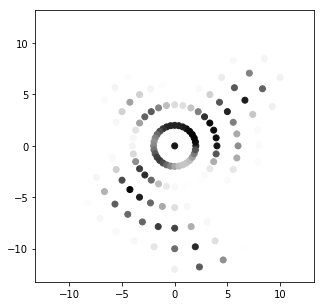

In [38]:
print("Number is ",y_hold[100])
rot_plot(x_hold_rotated_raw[100])

In [42]:
x_train_shift_features_sub = x_train_shift_features[(y_train != 9) & (y_train != 2)]
y_train_sub = y_train[(y_train != 9) & (y_train != 2)]
x_hold_rotated_features_sub = x_hold_rotated_features[(y_hold != 9) & (y_hold != 2)]
y_hold_sub = y_hold[(y_hold != 9) & (y_hold != 2)]
x_test_features_sub = x_test_features[(y_test != 9) & (y_test != 2)]
y_test_sub = y_test[(y_test != 9) & (y_test != 2)]

In [43]:
x_train_shift_features_sub.shape

(40044, 851)

In [44]:
# model_shift_sub2 = keras.Sequential([
#     #keras.layers.Dropout(.2,input_shape = (x_train_features.shape[1],), noise_shape=None, seed=None),
#     keras.layers.Dense(200, input_shape = (x_train_features.shape[1],), activation=tf.nn.relu),
#     #keras.layers.Dense(200, activation = tf.nn.relu),
#     #keras.layers.Dropout(.3, noise_shape=None, seed=None),
#     keras.layers.Dense(100, activation = tf.nn.relu),
#     #keras.layers.Dropout(.3, noise_shape=None, seed=None),
#     keras.layers.Dense(200, activation = tf.nn.relu),
#     #keras.layers.Dropout(.3, noise_shape=None, seed=None),
#     keras.layers.Dense(9, activation=tf.nn.softmax)
# ])

# model_shift_sub2.compile(optimizer='adam', 
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [45]:
# model_shift_sub2.fit(x_train_shift_features_sub, y_train_sub, verbose=1, epochs=20) 

In [46]:
# model_shift_sub2.evaluate(x_test_features_sub, y_test_sub)

In [47]:
model_shift_sub = keras.Sequential([
    #keras.layers.Dropout(.2,input_shape = (x_train_features.shape[1],), noise_shape=None, seed=None),
    keras.layers.Dense(200, input_shape = (x_train_features.shape[1],), activation=tf.nn.relu),
    #keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    keras.layers.Dense(200, activation = tf.nn.relu),
    #keras.layers.Dropout(.3, noise_shape=None, seed=None),
    keras.layers.Dense(9, activation=tf.nn.softmax)
])

model_shift_sub.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
model_shift_sub.fit(x_train_shift_features_sub, y_train_sub, verbose=1, epochs=60) 

Epoch 1/60
40044/40044 [==============================] - 6s 160us/sample - loss: 0.9916 - acc: 0.6403
Epoch 2/60
40044/40044 [==============================] - 6s 146us/sample - loss: 0.6099 - acc: 0.7909
Epoch 3/60
40044/40044 [==============================] - 6s 139us/sample - loss: 0.4787 - acc: 0.8373
Epoch 4/60
40044/40044 [==============================] - 5s 135us/sample - loss: 0.4202 - acc: 0.8589
Epoch 5/60
40044/40044 [==============================] - 6s 144us/sample - loss: 0.3774 - acc: 0.8742
Epoch 6/60
40044/40044 [==============================] - 5s 133us/sample - loss: 0.3471 - acc: 0.8847
Epoch 7/60
40044/40044 [==============================] - 5s 135us/sample - loss: 0.3220 - acc: 0.8925
Epoch 8/60
40044/40044 [==============================] - 5s 124us/sample - loss: 0.3005 - acc: 0.8991
Epoch 9/60
40044/40044 [==============================] - 5s 115us/sample - loss: 0.2836 - acc: 0.9068
Epoch 10/60
40044/40044 [==============================] - 5s 136us/sampl

In [49]:
model_shift_sub.evaluate(x_test_features_sub, y_test_sub)

7959/7959 [==============================] - 0s 59us/sample - loss: 0.3744 - acc: 0.9273


[0.37435428820463734, 0.9272522]

In [50]:
model_shift = keras.Sequential([
    #keras.layers.Dropout(.2,input_shape = (x_train_features.shape[1],), noise_shape=None, seed=None),
    keras.layers.Dense(200, input_shape = (x_train_features.shape[1],), activation=tf.nn.relu),
    #keras.layers.Dense(200, activation = tf.nn.relu),
    keras.layers.Dense(200, activation = tf.nn.relu),
    keras.layers.Dense(200, activation = tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

model_shift.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model_shift.fit(x_train_shift_features, y_train, verbose=1, epochs=60) 
#Will have trained for 60 epochs. Seems to train slowly once we get up to the 90's.However, accuracy on test set seems to stall at 80's after ~30-40 epochs.

Epoch 1/60
50000/50000 [==============================] - 7s 134us/sample - loss: 1.2023 - acc: 0.5749
Epoch 2/60
50000/50000 [==============================] - 6s 127us/sample - loss: 0.7886 - acc: 0.7295
Epoch 3/60
50000/50000 [==============================] - 6s 129us/sample - loss: 0.6425 - acc: 0.7810
Epoch 4/60
50000/50000 [==============================] - 7s 138us/sample - loss: 0.5638 - acc: 0.8081
Epoch 5/60
50000/50000 [==============================] - 7s 132us/sample - loss: 0.5148 - acc: 0.8254
Epoch 6/60
50000/50000 [==============================] - 6s 128us/sample - loss: 0.4750 - acc: 0.8381
Epoch 7/60
50000/50000 [==============================] - 7s 131us/sample - loss: 0.4412 - acc: 0.8491
Epoch 8/60
50000/50000 [==============================] - 7s 145us/sample - loss: 0.4179 - acc: 0.8573
Epoch 9/60
50000/50000 [==============================] - 6s 127us/sample - loss: 0.3917 - acc: 0.8681
Epoch 10/60
50000/50000 [==============================] - 6s 127us/sampl

In [52]:
model_shift.evaluate(x_test_features, y_test)

10000/10000 [==============================] - 1s 82us/sample - loss: 0.5897 - acc: 0.8779


[0.5897444898858667, 0.8779]

In [53]:
#Now try CNN on rotated data
model_CNNaug = Sequential()

model_CNNaug.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model_CNNaug.add(BatchNormalization(axis=-1))
model_CNNaug.add(Activation('relu'))
model_CNNaug.add(Conv2D(32, (3, 3)))
model_CNNaug.add(BatchNormalization(axis=-1))
model_CNNaug.add(Activation('relu'))
model_CNNaug.add(MaxPooling2D(pool_size=(2,2)))

model_CNNaug.add(Conv2D(64,(3, 3)))
model_CNNaug.add(BatchNormalization(axis=-1))
model_CNNaug.add(Activation('relu'))
model_CNNaug.add(Conv2D(64, (3, 3)))
model_CNNaug.add(BatchNormalization(axis=-1))
model_CNNaug.add(Activation('relu'))
model_CNNaug.add(MaxPooling2D(pool_size=(2,2)))

model_CNNaug.add(Flatten())

# Fully connected layer
model_CNNaug.add(Dense(512))
model_CNNaug.add(BatchNormalization())
model_CNNaug.add(Activation('relu'))
model_CNNaug.add(Dropout(0.2))
model_CNNaug.add(Dense(10))

model_CNNaug.add(Activation('softmax'))

model_CNNaug.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
model_CNNaug.fit(x_train_rotCNN, y_train, epochs=5)

Epoch 1/5
50000/50000 [==============================] - 116s 2ms/step - loss: 0.3531 - acc: 0.8882
Epoch 2/5
50000/50000 [==============================] - 115s 2ms/step - loss: 0.1721 - acc: 0.9454
Epoch 3/5
50000/50000 [==============================] - 116s 2ms/step - loss: 0.1346 - acc: 0.9574
Epoch 4/5
50000/50000 [==============================] - 116s 2ms/step - loss: 0.1156 - acc: 0.9632
Epoch 5/5
50000/50000 [==============================] - 116s 2ms/step - loss: 0.0929 - acc: 0.9692


In [55]:
model_CNNaug.evaluate(x_test_CNN, y_test)

10000/10000 [==============================] - 10s 1ms/step


[0.11251433226699009, 0.9649]

In [59]:
print("InvarFeatures, Full: ",model.evaluate(x_hold_rotated_features, y_hold))
print("InvarShift, Full: ", model_shift.evaluate(x_hold_rotated_features, y_hold))
print("InvarShift, Full, no 9 or 2 :", model_shift_sub.evaluate(x_hold_rotated_features_sub, y_hold_sub))
print("CNN: ",model_CNN.evaluate(x_hold_rotatedCNN, y_hold))
print("CNNaug: ",model_CNNaug.evaluate(x_hold_rotatedCNN, y_hold))

10000/10000 [==============================] - 0s 38us/sample - loss: 2.2909 - acc: 0.5793
InvarFeatures, Full:  [2.2908653934478758, 0.5793]
10000/10000 [==============================] - 0s 41us/sample - loss: 0.4912 - acc: 0.8925
InvarShift, Full:  [0.4912032798670232, 0.8925]
8049/8049 [==============================] - 0s 41us/sample - loss: 0.3264 - acc: 0.9322
InvarShift, Full, no 9 or 2 : [0.32636500371572386, 0.9321655]
10000/10000 [==============================] - 10s 1ms/step
CNN:  [4.423031184768677, 0.4512]
10000/10000 [==============================] - 10s 967us/step
CNNaug:  [0.11502193762399256, 0.9661]


In [57]:
# print("InvarFeatures, 2nd: ",model_secorder.evaluate(x_hold_rotated_features_secorder, y_test))

In [58]:
# predictions = np.array(np.argmax(model.predict(x_hold_features),axis=1))
# predictions = np.column_stack((predictions,np.array(np.argmax(model.predict(x_hold_rotated_features),axis=1))))
# predictions = np.column_stack((predictions,y_hold))